<a href="https://colab.research.google.com/github/woongchi98/woongchi98/blob/main/Lec2/Lab2_pytorch_regression_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab2. Pytorch Regression (Linear Regression vs MLP)  

이 실습에서는 Regression Problem을 `pytorch`로 해결해볼 겁니다! 두가지 모델(Linear Regression, MLP)을 둘 다 구현해보고 실제로 모델이 생각하는 데이터 분포를 시각화해서 MLP가 가지는 엄청난 non-linearity learning ability를 직접 살펴보는게 본 실습의 묘미입니다.


**이 문서를 구글 Colab에서 쉽게 실행해보는법**  
1. [제가 미리 만들어놓은 이 링크](https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning/blob/master/Lec2/Lab2_pytorch_regression_demo.ipynb)를 눌러 본 .ipynb 파일을 구글 Colab에서 바로 열 수 있습니다. 이때 구글에 로그인을 해야 합니다.
2. 아무 셀이나 선택한 후 `Ctrl+Enter`를 눌러 실행해보면 **[경고: 이 노트는 Google에서 작성하지 않았습니다]**라고 뜨는데 `실행 전에 모든 런타임 재설정`을 선택한 채로 `무시하고 계속하기`를 눌러줍니다.  
3. **[모든 런타임 재설정]** 이 뜰 텐데 `예`를 눌러줍니다.  
4. 잠시 구글 서버의 배치가 되면서 우상단에 `연결중` -> `초기화중` -> `연결됨`이 뜨면서 실행이 가능한 상태가 됩니다.  

**이 문서를 구글 Colab에서 어렵게 실행해보는법**  
1. 구글 Colab 문서를 하나 만들어줍시다. 
2. 본 문서에 있는 셀에 있는 코드를 드래그 한 후 `Ctrl+C`를 눌러줍시다.  
3. 구글 Colab 문서에 가서 `Ctrl+V`를 눌러줍시다.
4. 모든 셀이 다 복사될 때까지 1~3 무한반복!  

**구글 Colab에서 실습후 저장하는법**  
**쉽게 실행보는법**을 따라오셨다면 Colab에서 임시 노트북으로 열리기 때문에 `파일`->`드라이브로 저장`을 눌러서 여러분의 구글 드라이브에 저장하거나 `파일` -> `.ipynb 다운로드`를 눌러서 다운로드 해줍시다.   

*Written by. 조재영(whwodud9@kaist.ac.kr) 2019.01.20 *

### Install Pytorch (For Google Colab)

In [2]:
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)

1.0.0


In [1]:
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)

     |████████████████████████████████| 591.8 MB 622 bytes/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
     |████████████████████████████████| 17.4 MB 109 kB/s 
     |████████████████████████████████| 17.3 MB 24 kB/s 
     |████████████████████████████████| 12.8 MB 23 kB/s 
     |████████████████████████████████| 12.7 MB 56 kB/s 
     |████████████████████████████████| 11.8 MB 252 kB/s 
     |████████████████████████████████| 5.9 MB 13.8 MB/s 
     |████████████████████████████████| 6.6 MB 11.2 MB/s 
     |████████████████████████████████| 6.6 MB 57.3 MB/s 
     |████████████████████████████████| 4.0 MB 31.4 MB/s 
     |████████████████████████████████| 10.2 MB 17.2 MB/s 
     |████████████████████████████████| 10.1 MB 21.3 MB/s 
     |████████████████████████████████| 8.8 MB 15.0 MB/s 
     |████████████████████████████████| 2.6 MB 22.4 MB/s 
     |████████████████████████████████| 64 kB 3.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account a

### 1. Data Generation  (Preparation)

Regression 실습에 사용할 데이터를 만들어봅시다. 이번에는 X가 2차원 Y가 1차원인 상황입니다.  
아래 관계를 따르는 데이터 분포가 있으며 관측시 발생한 오차가 $e$가 더해져 있다고 합시다.  
$sin(x)$ 함수와 $log(x)$ 함수 모두 쉽게 생각할 수 있는 non-linear 함수이죠!  

$$ e \sim \mathcal{N} (0, 0.5) $$
$$y = \ 2 sin(x_1) + log({1 \over 2}x_2^2) + e$$  


**Data Set**  
$$X_{train} \in \mathcal{R}^{1600 \times 2}, Y_{train} \in \mathcal{R}^{1600}$$  
$$X_{val} \in \mathcal{R}^{400 \times 2}, Y_{val} \in \mathcal{R}^{400}$$  
$$X_{test} \in \mathcal{R}^{400 \times 2}, Y_{test} \in \mathcal{R}^{400}$$

X, Y 데이터를 3D 공간에 시각화 해볼까요?  
`numpy`의 `random.rand()` 함수를 사용하면 n개의 랜덤 샘플을 0~1의 uniform distribution에서 샘플링할 수 있습니다.

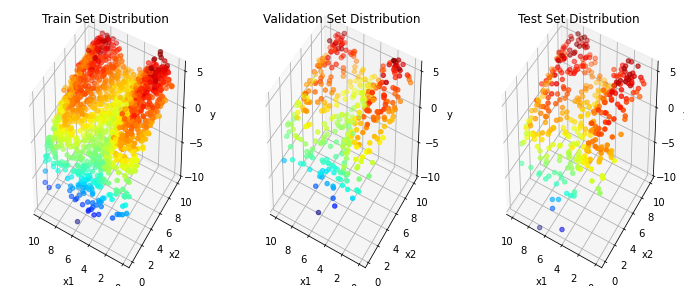

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# ====== Generating Dataset ====== #
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T  #첫번째 DIMENSION의 값이 우리가 갖고 있는 SAMPLE의 갯수가 되길 원한다.
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e

# ====== Split Dataset into Train, Validation, Test ======# 
train_X, train_y = X[:1600, :], y[:1600]
val_X, val_y = X[1600:2000, :], y[1600:2000]
test_X, test_y = X[2000:, :], y[2000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(12,5))  #여러개를 그릴때
ax1 = fig.add_subplot(1, 3, 1, projection='3d') #subplot추가
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution') ##학습 10번 시키고 validation 검증 > overfitting방지 
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

### 2. Hypothesis Define (Model Define)  

Linear Regression 시에 활용하는 H(x) = Wx + b를 파이토치로 구현할 때는 단순하게 `nn.Linear` 모듈을 하나 만들어주면 됩니다. 이 때`in_features`는 x의 차원이고, `out_features`는 y의 차원입니다.  


**Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200})$$  

$$H = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 1}, b_2 \in \mathcal{R}^{1}, H \in \mathcal{R}^{N  \times 1})$$

In [9]:
import torch
import torch.nn as nn


class LinearModel(nn.Module): ##클래스 상속 traning에 필요한 code들이 다 있다.
    def __init__(self):  ##생성할 때 딱 한번!!
        super(LinearModel, self).__init__() ##상속하고 꼭 써야한다. 그냥 규칙임
        self.linear = nn.Linear(in_features=2, out_features=1, bias=True) ## bias = 절편
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        return self.linear(x)
    
    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        x = self.linear1(x)
        x = self.relu(x)        ##25,26줄이 반복되는게 딥러닝
        x = self.linear2(x)
        return x

lm = LinearModel()
print(lm.linear.weight)

Parameter containing:
tensor([[-0.1401,  0.1365]], requires_grad=True)


### 3. Cost Function Define (Loss Function Define)  

Regression Problem 에서의 Loss Function을 작성해봅시다.  
파이토치의 `nn` 아래에는 다양한 Loss Function이 이미 구현되어 있습니다.  
[여기](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)에서 파이토치 내부에 구현되어 있는 MSE, Cross-Entropy, KL-Divergence 등을 확인할 수 있습니다.  
이 실습에서는 Regression Problem 이므로 Mean Squared Error 즉 MSE Loss를 써봅시다.

In [13]:
reg_loss = nn.MSELoss()

#uncomment for testing Loss Function

test_pred_y = torch.Tensor([0,0,0,0])
test_true_y = torch.Tensor([0,1,0,1])
print(type(torch.Tensor([0,1,0,1])))

print(reg_loss(test_pred_y, test_true_y))
print(reg_loss(test_true_y, test_true_y))
#이렇게 예를 넣어서 해보는거 좋다.

<class 'torch.Tensor'>
tensor(0.5000)
tensor(0.)


### 4. Train & Evaluation
이제 모델도 정의했고 Loss Function도 정의했으니 한번 학습시켜볼까요?  
저번에는 저희가 직접 파라미터(w 하나)에 따른 loss의 편미분을 유도하고 거기서 나온 그라디언트로 w를 업데이트했는데요.  
`pytorch`에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산해줍니다.  
이후 `optimizer.step()` 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줍니다. 

이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교하게됩니다. 
그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산합니다. 여기서 Metric으로는 mean absolute error(MAE)를 활용해보죵  

$$MAE(Y_{true}, Y_{predict}) = \sum_{i} | \ y_{true}^{(i)} - y_{predict}^{(i)} \ | $$

801 parameters
tensor([-2.4360, -1.4025, -2.0742,  ..., -1.8339, -1.7443, -2.4258],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
23.44990348815918


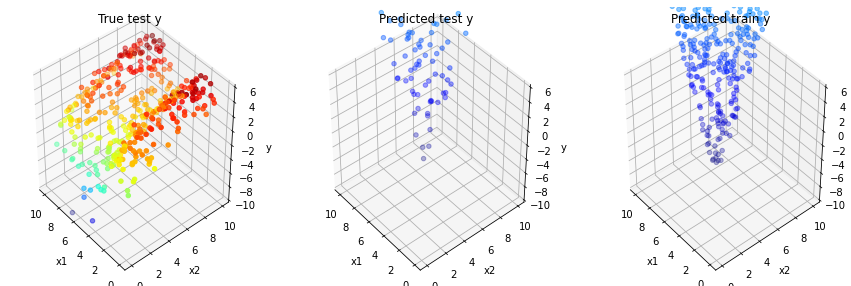

0 tensor(1093.8488, grad_fn=<MseLossBackward>)
tensor([48.3270, 19.4992, 33.9108,  ..., 36.9168, 29.5491, 36.2403],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1081.332763671875
tensor([-83.1101, -52.7773, -65.7478,  ..., -55.4065, -62.2759, -78.9373],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
4363.83935546875
tensor([0.4188, 0.7685, 1.5446,  ..., 0.4188, 0.4188, 3.2397],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
9.037979125976562
tensor([0.4327, 0.7434, 1.6526,  ..., 0.4347, 0.4327, 3.3818],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
8.851571083068848
tensor([0.4465, 0.7281, 1.7637,  ..., 0.4507, 0.4465, 3.5272],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
8.672933578491211
tensor([0.4

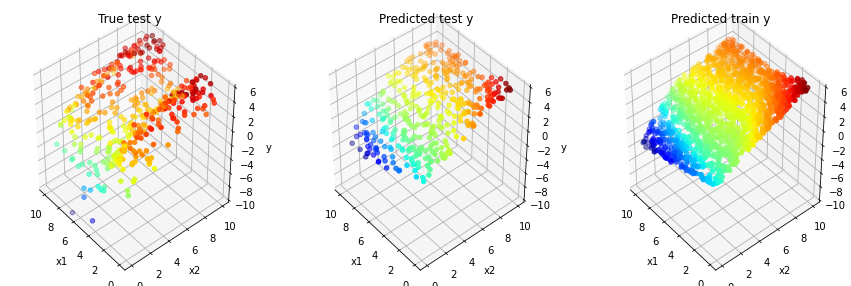

200 tensor(2.1730, grad_fn=<MseLossBackward>)
tensor([ 3.0455, -0.1318,  4.4718,  ...,  3.2342,  1.6768,  5.6428],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
2.3506479263305664
tensor([ 3.0473, -0.1345,  4.4724,  ...,  3.2333,  1.6779,  5.6425],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
2.3486602306365967
tensor([ 3.0490, -0.1372,  4.4730,  ...,  3.2324,  1.6792,  5.6421],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
2.3466827869415283
tensor([ 3.0508, -0.1397,  4.4736,  ...,  3.2315,  1.6805,  5.6417],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
2.3447132110595703
tensor([ 3.0526, -0.1421,  4.4742,  ...,  3.2306,  1.6819,  5.6414],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
2.34275341033

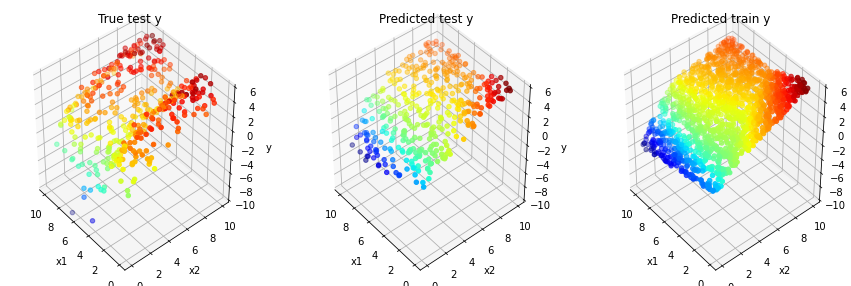

400 tensor(1.9527, grad_fn=<MseLossBackward>)
tensor([ 3.2753, -0.3940,  4.6232,  ...,  3.0555,  1.7543,  5.6546],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
2.075683116912842
tensor([ 3.2764, -0.3954,  4.6240,  ...,  3.0550,  1.7533,  5.6548],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
2.0746724605560303
tensor([ 3.2775, -0.3966,  4.6249,  ...,  3.0545,  1.7525,  5.6550],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
2.0736639499664307
tensor([ 3.2786, -0.3978,  4.6257,  ...,  3.0539,  1.7518,  5.6551],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
2.0726585388183594
tensor([ 3.2797, -0.3988,  4.6265,  ...,  3.0534,  1.7511,  5.6552],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
2.071655511856

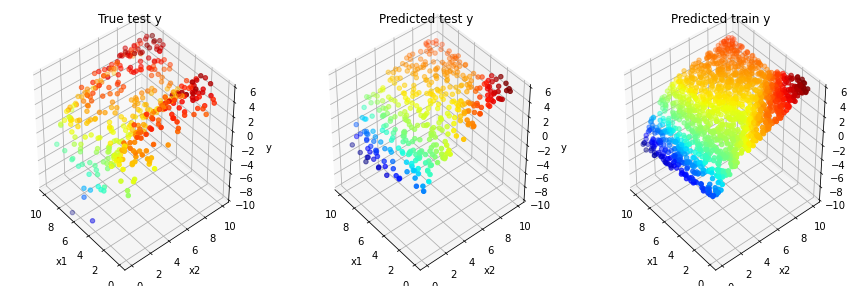

600 tensor(1.8311, grad_fn=<MseLossBackward>)
tensor([ 3.4361, -0.5203,  4.7533,  ...,  2.9478,  1.7060,  5.6463],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.9136099815368652
tensor([ 3.4367, -0.5206,  4.7539,  ...,  2.9474,  1.7061,  5.6462],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.912938117980957
tensor([ 3.4374, -0.5211,  4.7546,  ...,  2.9468,  1.7061,  5.6462],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.9122668504714966
tensor([ 3.4380, -0.5214,  4.7552,  ...,  2.9463,  1.7061,  5.6461],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.9115962982177734
tensor([ 3.4386, -0.5219,  4.7560,  ...,  2.9459,  1.7061,  5.6462],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.910926580429

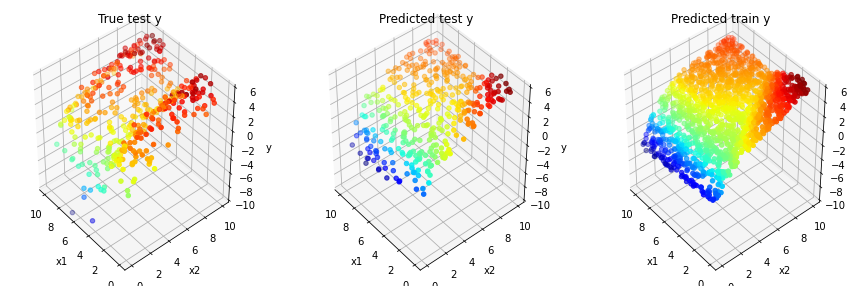

800 tensor(1.7495, grad_fn=<MseLossBackward>)
tensor([ 3.5510, -0.5835,  4.8629,  ...,  2.8650,  1.6870,  5.6083],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.7967405319213867
tensor([ 3.5516, -0.5836,  4.8632,  ...,  2.8647,  1.6869,  5.6080],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.7962455749511719
tensor([ 3.5521, -0.5838,  4.8635,  ...,  2.8643,  1.6867,  5.6076],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.7957518100738525
tensor([ 3.5526, -0.5840,  4.8639,  ...,  2.8640,  1.6865,  5.6073],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.7952604293823242
tensor([ 3.5532, -0.5841,  4.8642,  ...,  2.8637,  1.6864,  5.6070],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.79476964473

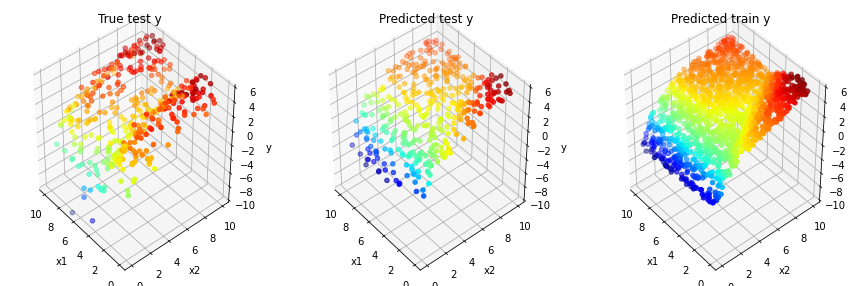

1000 tensor(1.6882, grad_fn=<MseLossBackward>)
tensor([ 3.6627, -0.6503,  4.9326,  ...,  2.8055,  1.6529,  5.5419],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.7058032751083374
tensor([ 3.6634, -0.6504,  4.9328,  ...,  2.8052,  1.6525,  5.5413],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.7054117918014526
tensor([ 3.6640, -0.6505,  4.9332,  ...,  2.8051,  1.6521,  5.5410],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.7050246000289917
tensor([ 3.6647, -0.6507,  4.9333,  ...,  2.8048,  1.6517,  5.5404],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.704637050628662
tensor([ 3.6653, -0.6516,  4.9335,  ...,  2.8045,  1.6503,  5.5398],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.70424473285

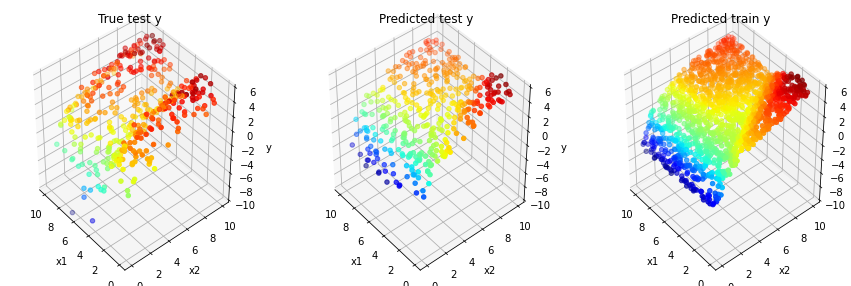

1200 tensor(1.6376, grad_fn=<MseLossBackward>)
tensor([ 3.7871, -0.6974,  4.9889,  ...,  2.7613,  1.5816,  5.4606],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.6358784437179565
tensor([ 3.7879, -0.6973,  4.9888,  ...,  2.7608,  1.5811,  5.4598],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.6355515718460083
tensor([ 3.7886, -0.6971,  4.9892,  ...,  2.7608,  1.5807,  5.4595],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.6352241039276123
tensor([ 3.7893, -0.6968,  4.9891,  ...,  2.7604,  1.5805,  5.4586],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.6348978281021118
tensor([ 3.7899, -0.6965,  4.9892,  ...,  2.7601,  1.5802,  5.4579],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.6345705986

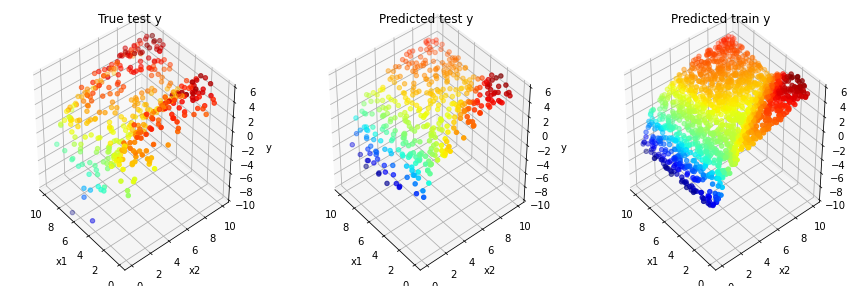

1400 tensor(1.5894, grad_fn=<MseLossBackward>)
tensor([ 3.8979, -0.7477,  5.0412,  ...,  2.7301,  1.5549,  5.3702],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.5741446018218994
tensor([ 3.8983, -0.7480,  5.0415,  ...,  2.7300,  1.5549,  5.3698],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.5738519430160522
tensor([ 3.8986, -0.7485,  5.0418,  ...,  2.7300,  1.5549,  5.3695],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.5735597610473633
tensor([ 3.8991, -0.7488,  5.0420,  ...,  2.7297,  1.5548,  5.3690],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.5732675790786743
tensor([ 3.8995, -0.7491,  5.0422,  ...,  2.7295,  1.5548,  5.3685],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.5729759931

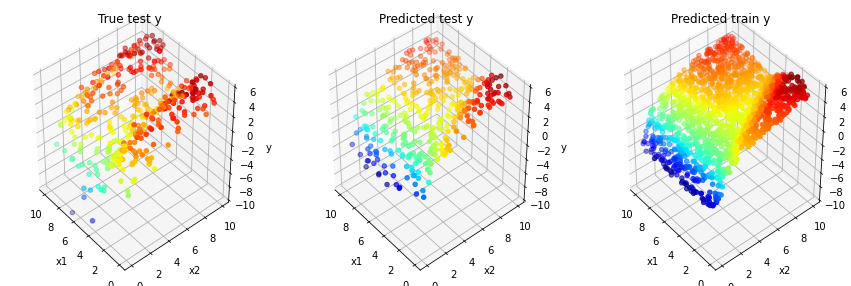

1600 tensor(1.5374, grad_fn=<MseLossBackward>)
tensor([ 3.9476, -0.8106,  5.0917,  ...,  2.6873,  1.5014,  5.2799],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.5164681673049927
tensor([ 3.9472, -0.8109,  5.0920,  ...,  2.6871,  1.5012,  5.2795],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.5161972045898438
tensor([ 3.9470, -0.8110,  5.0922,  ...,  2.6868,  1.5012,  5.2790],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.515926480293274
tensor([ 3.9466, -0.8113,  5.0922,  ...,  2.6864,  1.5011,  5.2783],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.5156563520431519
tensor([ 3.9464, -0.8115,  5.0926,  ...,  2.6863,  1.5011,  5.2780],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.51538634300

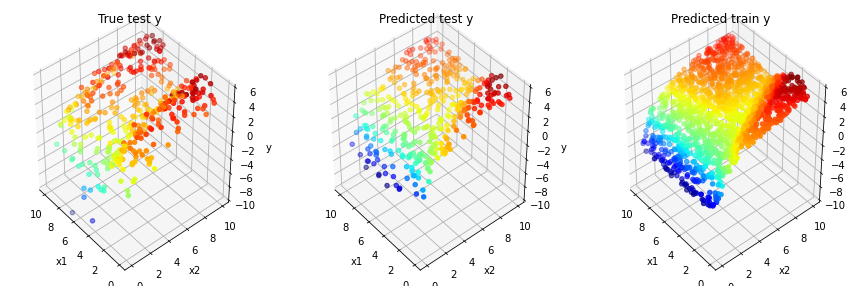

1800 tensor(1.4978, grad_fn=<MseLossBackward>)
tensor([ 3.9180, -0.8466,  5.1457,  ...,  2.6395,  1.5086,  5.1976],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.4647808074951172
tensor([ 3.9183, -0.8468,  5.1465,  ...,  2.6397,  1.5086,  5.1978],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.464543104171753
tensor([ 3.9185, -0.8471,  5.1468,  ...,  2.6395,  1.5086,  5.1974],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.4643058776855469
tensor([ 3.9187, -0.8473,  5.1469,  ...,  2.6391,  1.5085,  5.1969],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.4640685319900513
tensor([ 3.9190, -0.8477,  5.1475,  ...,  2.6392,  1.5086,  5.1968],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.46383190155

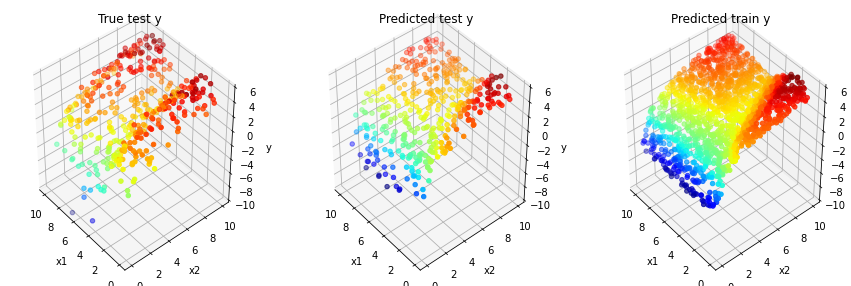

2000 tensor(1.4613, grad_fn=<MseLossBackward>)
tensor([ 3.9362, -0.9055,  5.2029,  ...,  2.6186,  1.5032,  5.1161],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.4208663702011108
tensor([ 3.9362, -0.9058,  5.2035,  ...,  2.6187,  1.5032,  5.1162],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.420664668083191
tensor([ 3.9361, -0.9061,  5.2035,  ...,  2.6183,  1.5031,  5.1155],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.42046320438385
tensor([ 3.9362, -0.9064,  5.2042,  ...,  2.6187,  1.5031,  5.1156],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.4202613830566406
tensor([ 3.9361, -0.9068,  5.2042,  ...,  2.6183,  1.5029,  5.1150],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.4200600385665

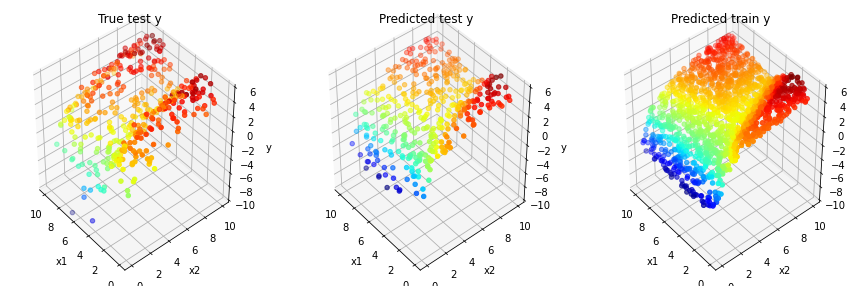

2200 tensor(1.4279, grad_fn=<MseLossBackward>)
tensor([ 3.9247, -0.9593,  5.2509,  ...,  2.5994,  1.4868,  5.0467],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3826725482940674
tensor([ 3.9246, -0.9593,  5.2513,  ...,  2.5995,  1.4867,  5.0467],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3824915885925293
tensor([ 3.9270, -0.9588,  5.2521,  ...,  2.6002,  1.4880,  5.0472],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3823131322860718
tensor([ 3.9248, -0.9601,  5.2513,  ...,  2.5991,  1.4866,  5.0458],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3821309804916382
tensor([ 3.9249, -0.9602,  5.2517,  ...,  2.5993,  1.4865,  5.0458],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3819509744

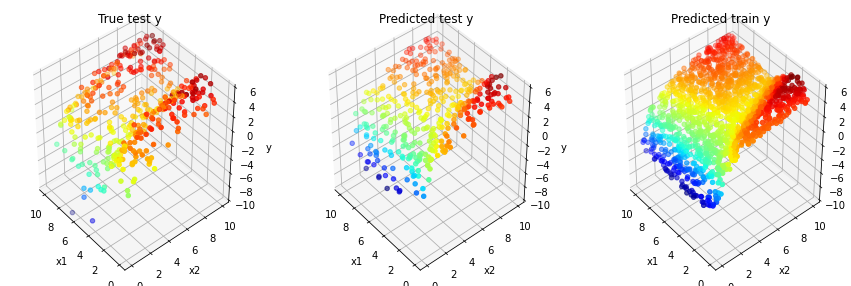

2400 tensor(1.3988, grad_fn=<MseLossBackward>)
tensor([ 3.9472, -1.0044,  5.2705,  ...,  2.5855,  1.4671,  4.9977],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3474549055099487
tensor([ 3.9473, -1.0045,  5.2707,  ...,  2.5855,  1.4669,  4.9976],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3472868204116821
tensor([ 3.9474, -1.0045,  5.2705,  ...,  2.5852,  1.4667,  4.9973],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.347118616104126
tensor([ 3.9474, -1.0044,  5.2706,  ...,  2.5851,  1.4666,  4.9971],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3469504117965698
tensor([ 3.9474, -1.0044,  5.2709,  ...,  2.5852,  1.4664,  4.9973],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.34678268432

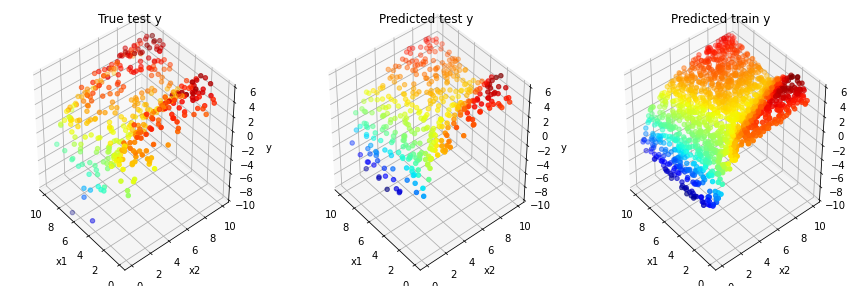

2600 tensor(1.3686, grad_fn=<MseLossBackward>)
tensor([ 3.9656, -1.0296,  5.2800,  ...,  2.5765,  1.4409,  4.9674],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3152180910110474
tensor([ 3.9658, -1.0298,  5.2796,  ...,  2.5761,  1.4410,  4.9669],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3150633573532104
tensor([ 3.9660, -1.0298,  5.2794,  ...,  2.5759,  1.4409,  4.9664],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3149093389511108
tensor([ 3.9661, -1.0300,  5.2795,  ...,  2.5760,  1.4408,  4.9663],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3147552013397217
tensor([ 3.9661, -1.0304,  5.2788,  ...,  2.5752,  1.4407,  4.9654],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.3146015405

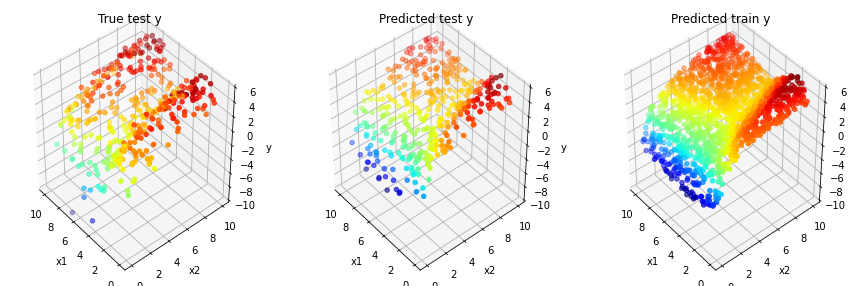

2800 tensor(1.3319, grad_fn=<MseLossBackward>)
tensor([ 3.9393, -1.0834,  5.2782,  ...,  2.5767,  1.4116,  4.9377],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2830297946929932
tensor([ 3.9400, -1.0834,  5.2772,  ...,  2.5758,  1.4120,  4.9364],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2828651666641235
tensor([ 3.9408, -1.0832,  5.2770,  ...,  2.5756,  1.4124,  4.9361],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2827006578445435
tensor([ 3.9410, -1.0838,  5.2769,  ...,  2.5755,  1.4124,  4.9358],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2825324535369873
tensor([ 3.9394, -1.0847,  5.2769,  ...,  2.5756,  1.4113,  4.9357],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2823619842

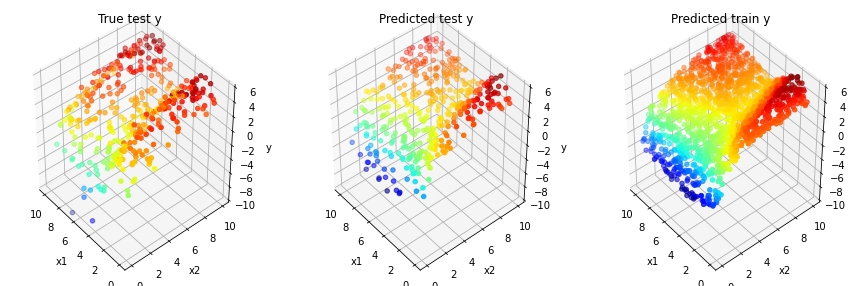

3000 tensor(1.2901, grad_fn=<MseLossBackward>)
tensor([ 3.9154, -1.1440,  5.2794,  ...,  2.5629,  1.3947,  4.9247],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2481272220611572
tensor([ 3.9153, -1.1446,  5.2787,  ...,  2.5620,  1.3945,  4.9239],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.24796462059021
tensor([ 3.9145, -1.1452,  5.2795,  ...,  2.5626,  1.3940,  4.9247],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2478022575378418
tensor([ 3.9142, -1.1456,  5.2790,  ...,  2.5619,  1.3938,  4.9241],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2476415634155273
tensor([ 3.9142, -1.1458,  5.2798,  ...,  2.5625,  1.3937,  4.9250],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.247481822967

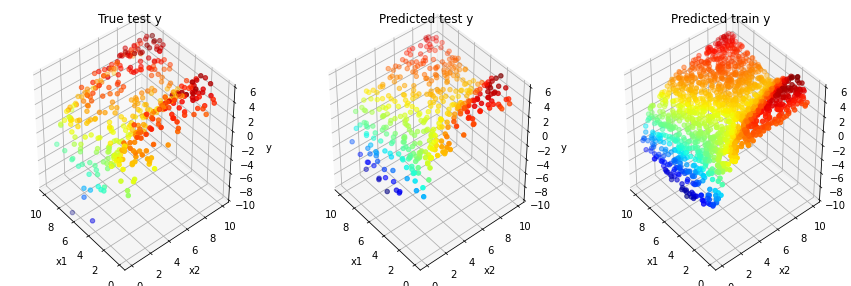

3200 tensor(1.2387, grad_fn=<MseLossBackward>)
tensor([ 3.8250, -1.2354,  5.3120,  ...,  2.5561,  1.4024,  4.9240],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2148001194000244
tensor([ 3.8249, -1.2356,  5.3112,  ...,  2.5547,  1.4027,  4.9229],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2146549224853516
tensor([ 3.8254, -1.2362,  5.3123,  ...,  2.5555,  1.4035,  4.9240],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2145103216171265
tensor([ 3.8253, -1.2367,  5.3119,  ...,  2.5545,  1.4038,  4.9233],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2143659591674805
tensor([ 3.8256, -1.2372,  5.3133,  ...,  2.5555,  1.4045,  4.9246],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.2142165899

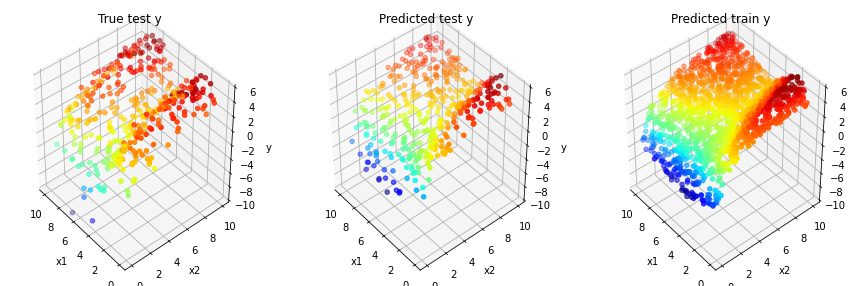

3400 tensor(1.2174, grad_fn=<MseLossBackward>)
tensor([ 3.8695, -1.3005,  5.3644,  ...,  2.5400,  1.3953,  4.9199],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1897372007369995
tensor([ 3.8689, -1.3007,  5.3644,  ...,  2.5397,  1.3949,  4.9196],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.189623475074768
tensor([ 3.8691, -1.3010,  5.3640,  ...,  2.5391,  1.3950,  4.9189],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1895105838775635
tensor([ 3.8694, -1.3012,  5.3643,  ...,  2.5391,  1.3951,  4.9190],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1893975734710693
tensor([ 3.8698, -1.3009,  5.3646,  ...,  2.5392,  1.3955,  4.9191],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.18928611278

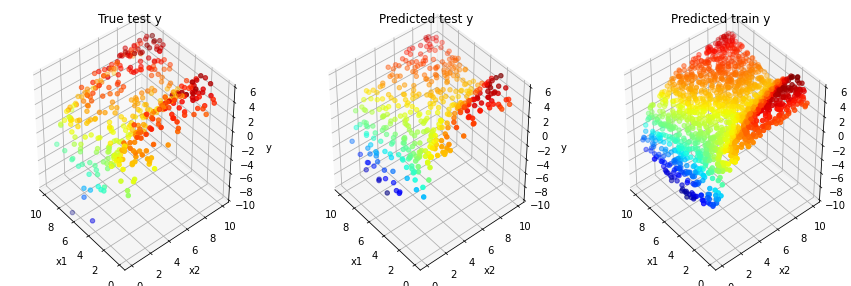

3600 tensor(1.2023, grad_fn=<MseLossBackward>)
tensor([ 3.9017, -1.3357,  5.4077,  ...,  2.5210,  1.3845,  4.9148],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1693555116653442
tensor([ 3.9042, -1.3347,  5.4089,  ...,  2.5219,  1.3859,  4.9157],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1692569255828857
tensor([ 3.9022, -1.3361,  5.4079,  ...,  2.5205,  1.3843,  4.9144],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1691590547561646
tensor([ 3.9050, -1.3350,  5.4094,  ...,  2.5218,  1.3858,  4.9158],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1690596342086792
tensor([ 3.9027, -1.3366,  5.4085,  ...,  2.5207,  1.3840,  4.9145],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1689610481

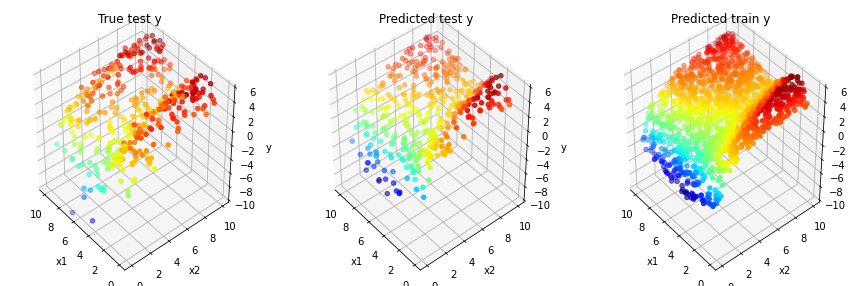

3800 tensor(1.1863, grad_fn=<MseLossBackward>)
tensor([ 3.9331, -1.3690,  5.4407,  ...,  2.5252,  1.3621,  4.9129],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.151114821434021
tensor([ 3.9331, -1.3692,  5.4408,  ...,  2.5251,  1.3620,  4.9128],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1510320901870728
tensor([ 3.9331, -1.3692,  5.4409,  ...,  2.5250,  1.3619,  4.9128],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1509490013122559
tensor([ 3.9334, -1.3691,  5.4410,  ...,  2.5249,  1.3620,  4.9128],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.1508666276931763
tensor([ 3.9333, -1.3693,  5.4412,  ...,  2.5248,  1.3618,  4.9129],
       grad_fn=<SqueezeBackward0>) tensor([ 3.9012, -2.9374,  5.2755,  ...,  2.5034,  1.4201,  5.5819])
1.15078377723

In [18]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error


# ====== Construct Model ====== #
# model = LinearModel()
# print(model.linear.weight)
# print(model.linear.bias)

model = MLPModel() # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.
#optim에 SGD class를 만들어줌, SGD,rmsprop,adam같은 optimizer들이 있다.
# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []


epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
#iteration : 파라미터가 한 번 업데이트 되는것 , ram공간 때문에 100개씩 끊어서 트레이닝 시킬 때도 있음>이걸 한번이 iteration, batch=100이면, batch는 epoch는
#batch size랑 데이터 몇개인가 이면 iteratio이랑 epoch 매칭가능
for i in range(epoch):
    
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다) // 모듈을 바꿔주는 역할
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    ###이거 두개 습관하시켜야함. 
    input_x = torch.Tensor(train_X) ##토치 연산하려면 torch.tensor로 다 바꿔줘야함.
    true_y = torch.Tensor(train_y)
    pred_y = model(input_x)  ## 이거 3개가 계산이 되면 끝난다. 
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    print(pred_y.squeeze(), true_y)
    loss = reg_loss(pred_y.squeeze(), true_y) #parameter upgrade하려면 gradient가 필요함
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언트를 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.item()) ##== list_train_loss.append(loss.detach().numpy())
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate MAE ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy() 
        mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_mae.append(mae)
        list_mae_epoch.append(i)
        
        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
        
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()
        
        plt.show()
        print(i, loss)

### 5. Report Experiment  
학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

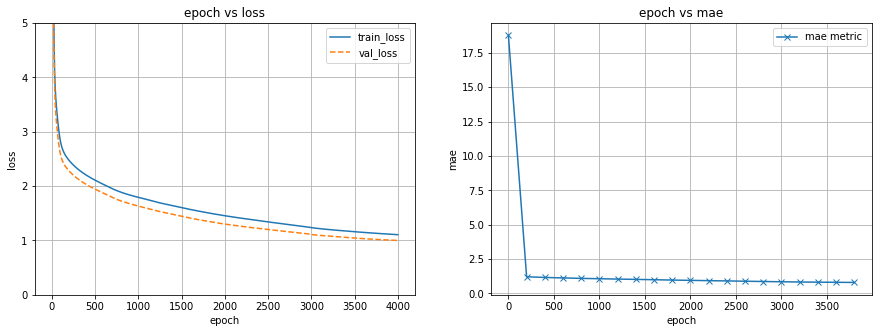

In [ ]:
##Training 값이 어떻게 되는지 모르니까 loss값을 저장하고 출력하는 습관을 가지도록 합시다!!

fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_mae_epoch, list_mae, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()